# Stock Classifier on 10x Stocks 2010 Start Date

3/30/2024

Authors: Gilbert

# Notes

1. Methodology leaves out some key companies that may have started later than Jan 2010 (e.g. TSLA), might be a good idea to explore those.
2. Model did not perform particularly well when asked to identify 2x stocks
3. Models done were Decision Tree, Random Forest, and Multilayer Perceptron Neural Network
4. All the features in Random Forest are about equal, so there may be some redundancy in features
5. Logarithmic regression did NOT converge, could be an issue
6. Next step is first two years of each company, rather than just have everyone start at 2010. This may significantly expand the training dataset, which I think is the biggest issue so far.

# 1. Import packages

In [4]:
import urllib.request, json , time, os, difflib, itertools
import pandas as pd
from multiprocessing.dummy import Pool
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import requests
import numpy as np
import matplotlib.pyplot as plt

# 2. Grab S&P 500 and NASDAQ stock tickers

In [5]:
from bs4 import BeautifulSoup

# funny code to lazily get all tickers
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = [row.find_all("td")[0].text.strip() for row in table.find_all("tr")[1:]]
    return tickers

In [6]:
sp500_tickers = get_sp500_tickers()
sp500_tickers.remove('BRK.B')
sp500_tickers.remove('BF.B')
sp500_tickers.remove('GOOGL')
print(sp500_tickers)
for ticker in sp500_tickers:
    if '.' in ticker:
        print(ticker)
print(len(sp500_tickers))

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 

In [7]:
def get_nasdaq_tickers():
    url = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
    data = pd.read_csv(url, sep='|')
    # parse out common + ordinary stock in security name, I have no clue what warrant and right mean
    data = data[data['Security Name'].str.contains('common|ordinary', case=False, na=False)]
    
    # Get the list of symbols
    symbols = data['Symbol'].tolist()
    
    # Third to last one was ZXY.A, what even
    del symbols[-3]
    

    return symbols

In [8]:
nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)
print(len(nasdaq_tickers))

['AACG', 'AACI', 'AADI', 'AAGR', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPL', 'ABAT', 'ABCB', 'ABCL', 'ABEO', 'ABIO', 'ABL', 'ABLV', 'ABNB', 'ABOS', 'ABSI', 'ABTS', 'ABUS', 'ABVC', 'ACAB', 'ACAC', 'ACAD', 'ACB', 'ACBA', 'ACCD', 'ACDC', 'ACET', 'ACGL', 'ACHC', 'ACHV', 'ACIC', 'ACIU', 'ACIW', 'ACLS', 'ACLX', 'ACMR', 'ACNB', 'ACNT', 'ACON', 'ACOR', 'ACRS', 'ACRV', 'ACST', 'ACT', 'ACTG', 'ACVA', 'ACXP', 'ADAG', 'ADBE', 'ADD', 'ADEA', 'ADI', 'ADIL', 'ADMA', 'ADN', 'ADP', 'ADPT', 'ADSE', 'ADSK', 'ADTH', 'ADTN', 'ADTX', 'ADUS', 'ADV', 'ADVM', 'AEAE', 'AEHL', 'AEHR', 'AEI', 'AEIS', 'AEMD', 'AENT', 'AEP', 'AERT', 'AEYE', 'AEZS', 'AFAR', 'AFBI', 'AFCG', 'AFIB', 'AFJK', 'AFMD', 'AFRI', 'AFRM', 'AFYA', 'AGAE', 'AGBA', 'AGEN', 'AGFY', 'AGIO', 'AGMH', 'AGNC', 'AGRI', 'AGYS', 'AHCO', 'AIB', 'AIHS', 'AIMD', 'AIP', 'AIRE', 'AIRG', 'AIRJ', 'AIRS', 'AIRT', 'AISP', 'AITR', 'AKAM', 'AKAN', 'AKBA', 'AKLI', 'AKRO', 'AKTS', 'AKYA', 'ALAB', 'ALBT', 'ALCE', 'ALCO', 'ALCY', 'ALDX', 'ALEC', 'ALGM', 'ALGN', 'ALGS', 'ALG

# 3. Loop through tickers and call yFinance

Test

In [9]:
# Define the ticker symbol
tickerSymbol = 'MVIS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='max')

# See your data
print(tickerDf, list(tickerDf.columns))
print(type('Date'))
print(tickerDf.index)
# date_diff = tickerDf['Date'].iloc[-1] - tickerDf['Date'].iloc[0]
# years_passed = date_diff / np.timedelta64(1, 'Y')
# print(years_passed)

start_date = "2024-01-01"
end_date = "2024-12-31"
curr = tickerDf.loc[start_date:end_date]
print(curr)

                            Open   High    Low  Close   Volume  Dividends  \
Date                                                                        
1996-08-27 00:00:00-04:00  49.00  49.00  38.00  42.00    70025        0.0   
1996-08-28 00:00:00-04:00  43.00  43.00  38.00  42.00    72763        0.0   
1996-08-29 00:00:00-04:00  41.50  43.50  40.00  43.00    60388        0.0   
1996-08-30 00:00:00-04:00  44.00  46.00  42.00  45.00    29988        0.0   
1996-09-03 00:00:00-04:00  45.00  51.00  43.00  50.00    35838        0.0   
...                          ...    ...    ...    ...      ...        ...   
2024-03-25 00:00:00-04:00   1.76   1.82   1.72   1.72  2016400        0.0   
2024-03-26 00:00:00-04:00   1.75   1.79   1.69   1.69  1748700        0.0   
2024-03-27 00:00:00-04:00   1.73   1.82   1.70   1.82  1849000        0.0   
2024-03-28 00:00:00-04:00   1.83   1.90   1.80   1.84  2136700        0.0   
2024-04-01 00:00:00-04:00   1.84   1.85   1.75   1.80  1849600        0.0   

In [10]:
# for ticker in sp500_tickers:
#     # Get data on this ticker
#     tickerData = yf.Ticker(ticker)

#     # Get the historical prices for this ticker
#     tickerDf = tickerData.history(period='max')
#     # tickerDf.reset_index(inplace=True)

#     date_diff = tickerDf['Date'].iloc[-1] - tickerDf['Date'].iloc[0]
#     years_passed = date_diff / np.timedelta64(1, 'Y')
#     if years_passed < 5: 
#         print(ticker, years_passed)

## Functions + Calculations

In [11]:
# Equation that finds the maximum percentage growth when provided with a list of values. Values are ordered from oldest to newest.
def general_growth(values):
    i = 0
    max_diff = 0
    while (values.iloc[i] == 0):
        i+=1
    overall_low = values.iloc[i]
    overall_high = values.iloc[i]
    curr_low = values.iloc[i]
    while (i < len(values)):
        if (values.iloc[i] != 0):
            if (values.iloc[i] < curr_low):
                curr_low = values.iloc[i]
            if ((values.iloc[i] - curr_low) > max_diff):
                max_diff = values.iloc[i] - curr_low
                overall_low = curr_low
                overall_high = values.iloc[i]
        i += 1
    if (overall_low == 0):
        overall_low = 0.01
    growth = (overall_high - overall_low) / float(overall_low) * 100
    return growth

# Takes in the first and last year as parameters, and returns a list of the maximum growth percentage for every year between the first year (inclusive) and last year (exclusive)
def annual_price_vol(data, first_year, last_year):
    annual_price_all = []
    annual_vol_all = []
    while (first_year < last_year):
        start_date = str(first_year) + '-01-01'
        end_date = str(first_year) + '-12-31'
        curr = data.loc[start_date:end_date]
        # print(curr)
        annual_price_all.append(general_growth(curr.iloc[:, 3]))
        annual_vol_all.append(general_growth(curr.iloc[:, 4]))
        first_year += 1
    return(annual_price_all, annual_vol_all)

# Similar to above function, but returns list of maximum growth percentage for each quarter between the first and last year starting with the start_quarter
def quarterly_price_vol(data, first_year, last_year):
    quarterly_price_all = []
    quarterly_vol_all = []
    quarter = 1
    while (first_year < last_year):
        if (quarter == 1):
            start_date = str(first_year) + '-01-01'
            end_date = str(first_year) + '-03-31'
        elif (quarter == 2):
            start_date = str(first_year) + '-04-01'
            end_date = str(first_year) + '-06-30'
        elif(quarter == 3):
            start_date = str(first_year) + '-07-01'
            end_date = str(first_year) + '-09-30'
        else:
            start_date = str(first_year) + '-10-01'
            end_date = str(first_year) + '-12-31'
            quarter = 0
            first_year += 1
        curr = data.loc[start_date:end_date]
        quarterly_price_all.append(general_growth(curr.iloc[:, 3]))
        quarterly_vol_all.append(general_growth(curr.iloc[:, 4]))
        quarter+=1
    return(quarterly_price_all, quarterly_vol_all)

In [12]:
all_rows = []
for ticker in nasdaq_tickers:
    try:
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='max')
        row = [ticker]
        row.extend(annual_price_vol(tickerDf, 2010, 2012)[0])
        row.extend(annual_price_vol(tickerDf, 2010, 2012)[1])
        row.extend(quarterly_price_vol(tickerDf, 2010, 2012)[0])
        row.extend(quarterly_price_vol(tickerDf, 2010, 2012)[1])
        all_rows.append(row)
        # print(row)
    except:
        print(str(ticker) + " data not available")

AACI data not available
AADI data not available
AAGR data not available
AAOI data not available
ABAT data not available
ABCL data not available
ABL data not available
ABLV data not available
ABNB data not available
ABOS data not available
ABSI data not available
ABTS data not available
ABVC data not available
ACAB data not available
ACAC data not available
ACB data not available
ACBA data not available
ACCD data not available
ACDC data not available
ACET data not available
ACHC data not available
ACIC data not available
ACIU data not available
ACLX data not available
ACMR data not available
ACON data not available
ACRS data not available
ACRV data not available
ACST data not available
ACT data not available
ACVA data not available
ACXP data not available
ADAG data not available
ADIL data not available
ADMA data not available
ADN data not available
ADPT data not available
ADSE data not available
ADTH data not available
ADTX data not available
ADV data not available
ADVM data not availab

WTMAR: Period 'max' is invalid, must be one of ['1d', '5d']


WTMA data not available
WTMAR data not available
WTO data not available
WULF data not available
WVE data not available
XAIR data not available
XBIO data not available
XBIT data not available
XBP data not available
XCUR data not available
XELA data not available
XELB data not available
XENE data not available
XERS data not available
XFIN data not available
XFOR data not available
XGN data not available
XLO data not available
XMTR data not available
XNCR data not available
XOS data not available
XP data not available
XPEL data not available
XPON data not available
XRTX data not available
XTIA data not available
XTKG data not available
XWEL data not available
XXII data not available
YGMZ data not available
YIBO data not available
YMAB data not available
YNDX data not available
YOSH data not available
YOTA data not available
YS data not available
YTRA data not available
ZAPP data not available


ZAZZT: No timezone found, symbol may be delisted


ZAZZT data not available


ZBZZT: No timezone found, symbol may be delisted


ZBZZT data not available
ZCAR data not available
ZCMD data not available
ZENV data not available
ZEO data not available
ZFOX data not available
ZG data not available
ZI data not available
ZIMV data not available
ZJYL data not available
ZKIN data not available
ZLS data not available
ZM data not available
ZNTL data not available
ZPTA data not available
ZS data not available
ZTEK data not available
ZURA data not available
ZVRA data not available
ZVSA data not available
ZYME data not available


In [13]:
# Convert to data frame
growth_df = pd.DataFrame(all_rows, columns=['Ticker', '2010-Price-Growth', '2010-Vol-Growth', '2011-Price-Growth', '2011-Vol-Growth', '2010Q1-Price-Growth', '2010Q2-Price-Growth','2010Q3-Price-Growth', '2010Q4-Price-Growth', '2011Q1-Price-Growth', '2011Q2-Price-Growth', '2011Q3-Price-Growth', '2011Q4-Price-Growth', '2010Q1-Vol-Growth', '2010Q2-Vol-Growth','2010Q3-Vol-Growth', '2010Q4-Vol-Growth', '2011Q1-Vol-Growth', '2011Q2-Vol-Growth', '2011Q3-Vol-Growth', '2011Q4-Vol-Growth'])

# Set 'Ticker' as the index
growth_df.set_index('Ticker', inplace=True)

In [14]:
print(growth_df)

        2010-Price-Growth  2010-Vol-Growth  2011-Price-Growth  \
Ticker                                                          
AACG            51.666686       241.081079      466300.000000   
AAL            153.039854        29.974832        1745.417695   
AAME            70.833372        19.999972       44700.000000   
AAON            59.380137        51.193578        1087.326465   
AAPL            69.471475        33.908363         331.308819   
...                   ...              ...                ...   
ZD              61.603380        25.003659         391.096197   
ZEUS            35.697197        68.645847         647.377622   
ZION           125.181450        33.698805         562.534595   
ZUMZ           158.828312        81.928444        8653.990610   
ZYXI            71.052388        66.666552      374766.666667   

        2011-Vol-Growth  2010Q1-Price-Growth  2010Q2-Price-Growth  \
Ticker                                                              
AACG       31437

# 4. Label the Data as a Buy Or Not

In [15]:
# Assuming growth_df is your DataFrame
# Initialize a new column 'buy' with zeros
growth_df['buy'] = 0

for ticker in growth_df.index:
    print(ticker)
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='max')
    
    # Get the price on 01/01/2010
    price_2010 = tickerDf.loc['2010', 'Close']
    if len(price_2010) > 0:  # Check if there are any prices in 2010
        price_2010 = price_2010.iloc[0]  # If so, take the first one
    else:
        continue  # If not, skip this ticker
    
    # Get the latest price
    latest_price = tickerDf.iloc[-1]['Close']
    
    # Check if the latest price is at least double the price on 01/01/2010
    if latest_price >= 10 * price_2010:
        # If the price did double, set 'buy' to 1 for this ticker
        growth_df.loc[ticker, 'buy'] = 1

print(growth_df)

AACG
AAL
AAME
AAON
AAPL
ABCB
ABEO
ABIO
ABUS
ACAD
ACGL
ACHV
ACIW
ACLS
ACNB
ACNT
ACOR
ACTG
ADBE
ADD
ADEA
ADI
ADP
ADSK
ADTN
ADUS
AEHL
AEHR
AEIS
AEMD
AEP
AEZS
AGEN
AGNC
AGYS
AIRT
AKAM
ALCO
ALGN
ALGT
ALKS
ALLT
ALNT
ALNY
ALOT
ALRS
ALTO
AMAT
AMD
AMED
AMGN
AMKR
AMNB
AMRN
AMSC
AMSF
AMSWA
AMTX
AMWD
AMZN
ANDE
ANGO
ANIK
ANIP
ANIX
ANSS
ANTE
APA
APDN
APEI
APOG
APPS
APTO
APWC
ARAY
ARCB
ARKR
ARLP
AROW
ARQ
ARTNA
ARTW
ARWR
ASPS
ASRT
ASRV
ASTC
ASTE
ASTH
ASUR
ASYS
ATEC
ATLC
ATLO
ATNI
ATRC
ATRI
ATRO
ATSG
AUBN
AUDC
AVAV
AVDL
AVGO
AVNW
AVT
AVXL
AWH
AWRE
AXDX
AXGN
AXON
AXTI
AZPN
AZTA
BANF
BANR
BBGI
BBSI
BCBP
BCDA
BCLI
BCML
BCPC
BCRX
BECN
BELFA
BELFB
BFC
BFIN
BGC
BGFV
BHRB
BIDU
BIIB
BIMI
BIOL
BJRI
BKNG
BKR
BKYI
BLDP
BLFS
BLIN
BLKB
BLNK
BMRA
BMRC
BMRN
BOKF
BOOM
BOSC
BOTJ
BPOP
BPTH
BRID
BRKL
BRKR
BSET
BSRR
BUSE
BVFL
BWEN
BYFC
BYRN
CAAS
CAC
CACC
CAKE
CALM
CAMP
CAMT
CAPR
CAR
CARE
CARV
CASH
CASI
CASS
CASY
CATC
CATY
CBAN
CBAT
CBFV
CBRL
CBSH
CCBG
CCEP
CCNE
CCOI
CCRN
CDMO
CDNS
CDXC
CDZI
CECO
CELH
CENT
CENTA
CENX
CERS


In [16]:
count = 0
for ticker in growth_df.index:
    if (growth_df.loc[ticker, 'buy'] == 0):
        count += 1
        print(ticker)
print(count)

AACG
AAL
AAME
ABCB
ABEO
ABIO
ABUS
ACHV
ACIW
ACNB
ACNT
ACOR
ACTG
ADD
ADEA
ADI
ADP
ADTN
AEHL
AEHR
AEIS
AEMD
AEP
AEZS
AGEN
AGNC
AGYS
AIRT
AKAM
ALCO
ALGT
ALKS
ALLT
ALNY
ALOT
ALRS
ALTO
AMED
AMGN
AMKR
AMNB
AMRN
AMSC
AMSF
AMSWA
AMWD
ANDE
ANGO
ANIK
ANIP
ANIX
ANSS
ANTE
APA
APDN
APEI
APOG
APPS
APTO
APWC
ARAY
ARCB
ARKR
ARLP
AROW
ARQ
ARTNA
ARTW
ARWR
ASPS
ASRT
ASRV
ASTC
ASTE
ASUR
ASYS
ATEC
ATLC
ATLO
ATNI
ATRC
ATRI
ATRO
ATSG
AUBN
AUDC
AVAV
AVDL
AVNW
AVT
AVXL
AWH
AWRE
AXDX
AXGN
AXTI
AZTA
BANF
BANR
BBGI
BCBP
BCDA
BCLI
BCML
BCPC
BCRX
BECN
BELFA
BELFB
BFIN
BGC
BGFV
BHRB
BIDU
BIIB
BIMI
BIOL
BJRI
BKR
BKYI
BLDP
BLIN
BLKB
BLNK
BMRA
BMRC
BMRN
BOKF
BOOM
BOSC
BOTJ
BPOP
BPTH
BRID
BRKL
BRKR
BSET
BSRR
BUSE
BVFL
BWEN
BYFC
BYRN
CAAS
CAC
CAKE
CALM
CAMP
CAPR
CARE
CARV
CASH
CASI
CASS
CATC
CATY
CBAN
CBAT
CBFV
CBRL
CBSH
CCBG
CCEP
CCNE
CCRN
CDMO
CDXC
CDZI
CECO
CENT
CENTA
CENX
CERS
CEVA
CFBK
CFFI
CFFN
CGEN
CHCI
CHCO
CHKP
CHMG
CHNR
CHRW
CHTR
CINF
CIVB
CJJD
CLAR
CLDX
CLMT
CLNE
CLRB
CLRO
CLWT
CMCO
CMCSA
CMCT
CME
CMPR
CMTL
CN

In [17]:
# test with dropping volume metrics
price_growth_df = growth_df.drop('2010Q1-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2010Q2-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2010Q3-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2010Q4-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2011Q1-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2011Q2-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2011Q3-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2011Q4-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2010-Vol-Growth', axis=1)
price_growth_df = price_growth_df.drop('2011-Vol-Growth', axis=1)

In [24]:
print(price_growth_df)

growth_df.to_csv("clean_data/growth.csv")


        2010-Price-Growth  2010-Vol-Growth  2011-Price-Growth  \
Ticker                                                          
AACG            51.666686       241.081079      466300.000000   
AAL            153.039854        29.974832        1745.417695   
AAME            70.833372        19.999972       44700.000000   
AAON            59.380137        51.193578        1087.326465   
AAPL            69.471475        33.908363         331.308819   
...                   ...              ...                ...   
ZD              61.603380        25.003659         391.096197   
ZEUS            35.697197        68.645847         647.377622   
ZION           125.181450        33.698805         562.534595   
ZUMZ           158.828312        81.928444        8653.990610   
ZYXI            71.052388        66.666552      374766.666667   

        2011-Vol-Growth  2010Q1-Price-Growth  2010Q2-Price-Growth  \
Ticker                                                              
AACG       31437

# 5. Split into Testing and Training Sets

In [27]:
# import from csv (to speed up testing)
growth_df = pd.read_csv("clean_data/growth.csv")#.set_index(SYMBOL_COLUMN_NAME, verify_integrity=True)

growth_df.set_index('Ticker', inplace=True)


In [28]:
from sklearn.model_selection import train_test_split
# Split the data into features (X) and target (y)
X = growth_df.drop('buy', axis=1)
y = growth_df['buy']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X, y)
print(X_train, X_test, y_train, y_test)

        2010-Price-Growth  2010-Vol-Growth  2011-Price-Growth  \
Ticker                                                          
AACG            51.666686       241.081079      466300.000000   
AAL            153.039854        29.974832        1745.417695   
AAME            70.833372        19.999972       44700.000000   
AAON            59.380137        51.193578        1087.326465   
AAPL            69.471475        33.908363         331.308819   
...                   ...              ...                ...   
ZD              61.603380        25.003659         391.096197   
ZEUS            35.697197        68.645847         647.377622   
ZION           125.181450        33.698805         562.534595   
ZUMZ           158.828312        81.928444        8653.990610   
ZYXI            71.052388        66.666552      374766.666667   

        2011-Vol-Growth  2010Q1-Price-Growth  2010Q2-Price-Growth  \
Ticker                                                              
AACG       31437

# 6. Train Models

In [1]:
from sklearn.neural_network import MLPClassifier

# Train the model
mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train, y_train)

# Make predictions on the test set
mlp_predictions = mlp_clf.predict(X_test)

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [30]:
print(mlp_predictions)

[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [69]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)
lr_predictions = lr_clf.predict(X_test)
print(lr_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


c:\Users\aliss\anaconda3\envs\unicorn_pred\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
dt_predictions = dt_clf.predict(X_test)
print(dt_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]


In [2]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(100)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
print(rf_predictions)

# Get feature importances
importances = rf_clf.feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, importances):
    print(f"The importance of {feature} is {importance:.2f}")

NameError: name 'X_train' is not defined

In [72]:
print(np.array(y_test))

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


# 7. Model Evaluation

In [73]:
from sklearn.metrics import confusion_matrix

# Compare the predicted values with the actual values
cm = confusion_matrix(y_test, mlp_predictions)

# The first row, first column represents the true negatives (TN).
# The first row, second column represents the false positives (FP).
# The second row, first column represents the false negatives (FN).
# The second row, second column represents the true positives (TP).

print(cm)

[[180  19]
 [ 37   2]]


[[174  28]
 [ 37   2]]


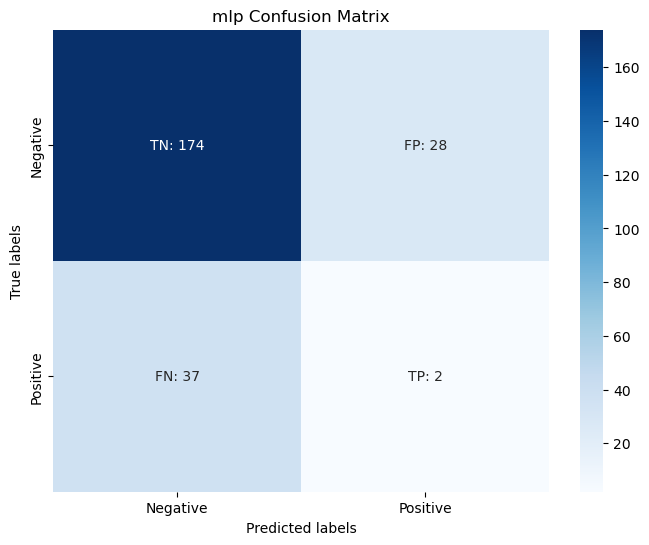

In [ ]:
import seaborn as sns
import numpy as np

class_labels = ["Negative", "Positive"]

try:
    print(cm)
except NameError as e:
    cm = np.array([[174,  28], [ 37,   2]]) # taken from stdout of cell above, didn't want to re-run whole notebook
    print(cm)
    print("WARNING: THIS FIGURE HAS BEEN GENERATED FROM A HARDCODED CONFUSION MATRIX")
    print("PLEASE CONFIRM THIS MATCHES THE ACTUAL RESULTS FROM THE MODEL")

# The first row, first column represents the true negatives (TN).
# The first row, second column represents the false positives (FP).
# The second row, first column represents the false negatives (FN).
# The second row, second column represents the true positives (TP).
# model_type is a string representing the type of model that generated this confusion matrix.
# model_type is only used to generate the plot's title
def show_confusion_matrix(cm, model_type):
    annotations = np.char.add(np.array([["TN: ", "FP: "], ["FN: ", "TP: "]]), cm.astype("str"))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{model_type} Confusion Matrix')
    plt.show()

show_confusion_matrix(cm, 'mlp')

# if the bottom row labels aren't displaying, try upgrading to seaborn version 0.13

In [74]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test, mlp_predictions)

print(f"The accuracy of the MLP model is {accuracy:.2f}")

# Decision Trees
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"The accuracy of the Decision Trees model is {dt_accuracy:.2f}")

# Random Forests
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"The accuracy of the Random Forests model is {rf_accuracy:.2f}")

The accuracy of the MLP model is 0.76
The accuracy of the Decision Trees model is 0.76
The accuracy of the Random Forests model is 0.84


### Root Mean Squared Error

In [3]:
from sklearn.metrics import root_mean_squared_error

print(f"Root Mean Squared Error of the MLP model is {root_mean_squared_error(y_test, mlp_predictions)}")
print(f"Root Mean Squared Error of the Decision Trees model is {root_mean_squared_error(y_test, dt_predictions)}")
print(f"Root Mean Squared Error of the Random Forest model is {root_mean_squared_error(y_test, rf_predictions)}")

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (c:\Users\aliss\anaconda3\envs\unicorn_pred\Lib\site-packages\sklearn\metrics\__init__.py)

### R Squared

In [90]:
from sklearn.metrics import r2_score

print(f"R^2 of the MLP model is {r2_score(y_test, mlp_predictions)}")
print(f"R^2 of the Decision Trees model is {r2_score(y_test, dt_predictions)}")
print(f"R^2 of the Random Forest model is {r2_score(y_test, rf_predictions)}")

R^2 of the MLP model is -0.7173044710733154
R^2 of the Decision Trees model is -0.7173044710733154
R^2 of the Random Forest model is -0.1959798994974875


### F-Measure

In [89]:
from sklearn.metrics import f1_score

def FMeasure(y_test, predictions):
    return f1_score(y_test, predictions)

print(f"F-Measure of the MLP model is {FMeasure(y_test, mlp_predictions)}")
print(f"F-Measure of the Decision Trees model is {FMeasure(y_test, dt_predictions)}")
print(f"F-Measure of the Random Forest model is {FMeasure(y_test, rf_predictions)}")

F-Measure of the MLP model is 0.06666666666666667
F-Measure of the Decision Trees model is 0.24324324324324323
F-Measure of the Random Forest model is 0.0


### Normalized Mutual Information

In [76]:
from sklearn.metrics.cluster import normalized_mutual_info_score

def NMI(truth, predictions):
    return normalized_mutual_info_score(truth, predictions, average_method='geometric')

print(f"Normalized Mutual Information of the MLP model is {NMI(y_test, mlp_predictions)}")
print(f"Normalized Mutual Information of the Decision Trees model is {NMI(y_test, dt_predictions)}")
print(f"Normalized Mutual Information of the Random Forest model is {NMI(y_test, rf_predictions)}")

Normalized Mutual Information of the MLP model is 0.005159248928984967
Normalized Mutual Information of the Decision Trees model is 0.011456836093605156
Normalized Mutual Information of the Random Forest model is 0.0


### ROC Curve

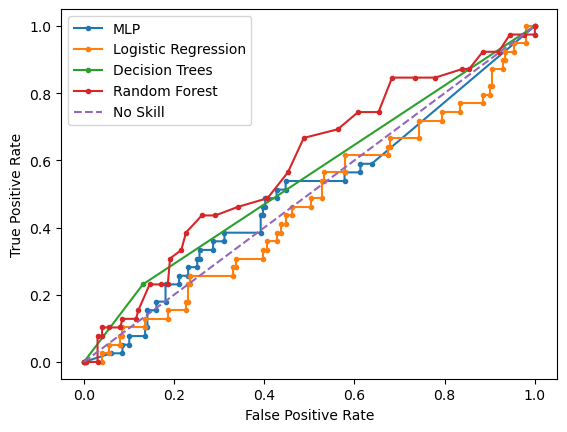

In [84]:
from sklearn.metrics import roc_curve

def ROCCurve(model):
    yhat = model.predict_proba(X_test)
    pos_probs = yhat[:,1]
    fpr, tpr, _ = roc_curve(y_test, pos_probs)
    return fpr, tpr

fpr_mlp, tpr_mlp = ROCCurve(mlp_clf)
fpr_dt, tpr_dt = ROCCurve(dt_clf)
fpr_lr, tpr_lr = ROCCurve(lr_clf)
fpr_rf, tpr_rf = ROCCurve(rf_clf)
plt.plot(fpr_mlp, tpr_mlp, marker='.', label='MLP')
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, marker='.', label='Decision Trees')
plt.plot(fpr_rf, tpr_rf, marker='.', label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()